In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
TRAIN = 'hw2_adaboost_train.dat'
TEST = 'hw2_adaboost_test.dat'

train = pd.read_csv(TRAIN, sep=' ', header=None)
train = train.astype(float)
orders = [np.argsort(train[0]), np.argsort(train[1])]
trainX = train[train.columns[:-1]]
trainY = train[train.columns[-1]]

test = pd.read_csv(TEST, sep=' ', header=None)
testX = test[test.columns[:-1]]
testY = test[test.columns[-1]]


In [3]:
# returns (s, i, e)
Totals = []
def FindBestThresh(xs: pd.DataFrame, ys: pd.DataFrame, feature: int, orders : list) -> tuple:
    Total = sum(abs(y) for y in ys)
    Totals.append(Total)
    BestErrorPos = abs(sum((y if y <= 0 else 0) for y in ys))
    BestErrorCountPos = sum((1 if y <= 0 else 0) for y in ys)
    BestErrorCountNeg = sum((1 if y > 0 else 0) for y in ys)
    BestErrorNeg = abs(sum((y if y > 0 else 0) for y in ys))
    BestThreshPos = 0
    BestThreshNeg = 0
    curErrorPos = BestErrorPos
    curErrorNeg = BestErrorNeg


    for j in range(len(orders[feature]) - 1):
        i = orders[feature][j]
        y = ys[i]

        # if y on pos side of NEG, NEG has more error if y < 0 (- <0 == increase)
        # # else less error if y > 0 (- >0 == decrease)
        curErrorNeg -= y


        # if y on pos side of POS, POS has less error if y < 0 (+ <0 == decrease)
        # # else more error if y > 0 (+ >0 == increase)
        curErrorPos += y

        if curErrorPos < BestErrorPos:
            BestErrorPos = curErrorPos
            BestThreshPos = j

        if curErrorNeg < BestErrorNeg:
            BestErrorNeg = curErrorNeg
            BestThreshNeg = j

    # Convert to midpoints
    if BestThreshPos < len(xs) - 1:
        BestThreshPos = (xs[feature][orders[feature][BestThreshPos]] + xs[feature][orders[feature][BestThreshPos + 1]]) / 2
    else:
        BestThreshPos = -float('inf')
    
    if BestThreshNeg < len(xs) - 1:
        BestThreshNeg = (xs[feature][orders[feature][BestThreshNeg]] + xs[feature][orders[feature][BestThreshNeg + 1]]) / 2
    else:
        BestThreshNeg = -float('inf')

    wrongP = 0
    wrongN = 0
    for i in range(len(xs[0])):

        if xs[feature][i] < BestThreshPos:
            predP = 1
        else:
            predP = -1
        if ys[i] * predP > 0:
            wrongP += 1
            
        if xs[feature][i] < BestThreshNeg:
            predN = -1
        else:
            predN = 1
        if ys[i] * predN > 0:
            wrongN += 1

    # Return better of NEG or POS
    if BestErrorPos < BestErrorNeg:
        return (1, BestThreshPos, wrongP / 100)
    else:
        return (-1, BestThreshNeg, wrongN / 100)

def BestThreshOfFeature(xs : list, ys : list, features : list, orders : list) -> tuple:
    Bs = None
    Bi = None
    Be = float('inf')
    Bf = None
    for feature in features:
        s, i, e = FindBestThresh(xs, ys, feature, orders)
        if e < Be:
            Bs = s
            Bi = i
            Be = e
            Bf = feature

    return ((Bs, Bi), Be, Bf)

def GenerateGOpt(iterations, xs, ys, features, orders):
    Gs = []
    for _ in range(iterations):
        g, e, f = BestThreshOfFeature(xs, ys, features, orders)
        d = np.sqrt((1-e) / e)
        UpdateYOpt(xs, ys, g, d, f)
        Gs.append(((g, f), np.log(d)))
    
    return Gs

def UpdateYOpt(xs, ys, g, d, feature):
    s, thresh = g
    for i in range(len(xs[0])):
        if xs[feature][i] < thresh:
            pred = s
        else:
            pred = -s

        if ys[i] * pred < 0:
            ys[i] = ys[i] / d
        else:
            ys[i] = ys[i] * d
            
def CalcEinWithStump(xs : pd.DataFrame, ys : pd.DataFrame, g: tuple) -> list:
    ((s, thresh), feature), _ = g
    prediction = []
    for i in range(len(xs)):
        if xs[feature][i] < thresh:
            pred = s
        else:
            pred = -s

        if ys[i] * pred < 0:
            prediction.append(-1)
        else:
            prediction.append(1)
    
    return prediction


In [4]:
features = [0, 1]
iterations = 300
Totals = []
G = GenerateGOpt(iterations, trainX, trainY, features, orders)


train = pd.read_csv(TRAIN, sep=' ', header=None)
train = train.astype(float)
orders = [np.argsort(train[0]), np.argsort(train[1])]

trainX = train[train.columns[:-1]]
trainY = train[train.columns[-1]]

alphas = []
predictions = []
for g in G:
    _, a = g
    alphas.append(a)
    predictions.append(CalcEinWithStump(trainX, trainY, g))


In [5]:
wrongs = []
for t in range(iterations):
    wrong = 0
    for i in range(len(trainY)):
        if trainY[i] != predictions[t][i]:
            wrong += 1
    wrongs.append(wrong / len(trainY))

rates = []
for i in range(len(G)):
    rates.append(np.array(predictions[i]) * alphas[i])

wrongG = []
for i in range(iterations):
    wrong = 0
    pred = np.sum(rates[0:i + 1], axis=0)
    for j in range(len(trainY)):
        if pred[j] * trainY[j] < 0:
            wrong += 1
    wrongG.append(wrong / len(trainY))



In [6]:
outPredictions = []
for g in G:
    outPredictions.append(CalcEinWithStump(testX, testY, g))

ratesOut = []
for i in range(len(G)):
    ratesOut.append(np.array(outPredictions[i]) * alphas[i])

wrongGOut = []
for i in range(iterations):
    wrong = 0
    pred = np.sum(ratesOut[0:i + 1], axis=0)
    for j in range(len(testY)):
        if pred[j] * testY[j] < 0:
            wrong += 1
    wrongGOut.append(wrong / len(testY))

Ein(gT):	0.82
Ein(G):		0.18
UT:		1.6314737366969495e+41
Eout(G):	0.145


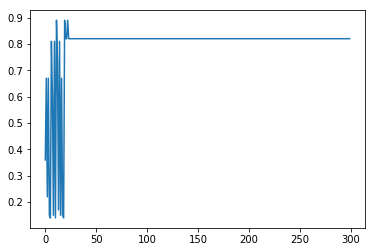

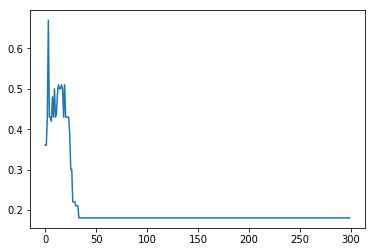

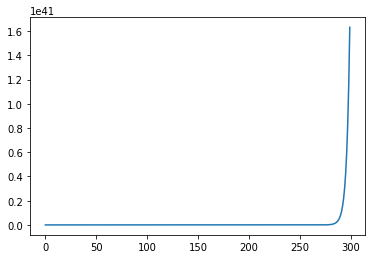

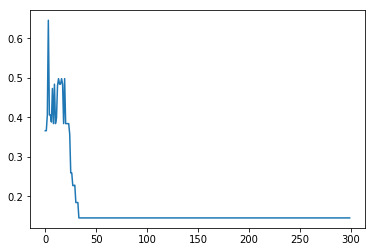

In [7]:

#13
print(f"Ein(gT):\t{wrongs[-1]}")
print(f"Ein(G):\t\t{wrongG[-1]}")
print(f"UT:\t\t{Totals[-1]}")
print(f"Eout(G):\t{wrongGOut[-1]}")
plt.plot(wrongs)
plt.show()

#14
plt.plot(wrongG)
plt.show()

#15
plt.plot(Totals[1::2])
plt.show()
#16
plt.plot(wrongGOut)
plt.show()